In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error, r2_score

- **train_test_split** (from `sklearn.model_selection`):  
  Splits arrays or matrices into random train and test subsets. It is commonly used to create training and testing datasets for machine learning models.

- **StandardScaler** (from `sklearn.preprocessing`):  
  Scales the features by removing the mean and scaling to unit variance. It standardizes data for machine learning algorithms that assume the data to be normally distributed.

- **LinearRegression** (from `sklearn.linear_model`):  
  A linear model that estimates the relationship between the target variable and one or more explanatory variables by fitting a linear equation to observed data.

- **Lasso** (from `sklearn.linear_model`):  
  Lasso (Least Absolute Shrinkage and Selection Operator) is a linear model that performs both variable selection and regularization to enhance prediction accuracy and interpretability by penalizing large coefficients.

- **ElasticNet** (from `sklearn.linear_model`):  
  A linear model that combines penalties from both Lasso and Ridge regression, helping to deal with highly correlated features and model generalization.

- **mean_squared_error** (from `sklearn.metrics`):  
  Calculates the mean squared error between the true and predicted values. It is used to measure the average squared difference between the actual and predicted values in regression problems.

- **r2_score** (from `sklearn.metrics`):  
  Computes the R² (coefficient of determination) regression score, which measures the proportion of variance in the dependent variable that is predictable from the independent variables. Higher values indicate better model performance.


### (a) Brief Exploration of Dataset

In [2]:
data = pd.read_csv('niftybankdata.csv')

print(data.head())

print(data.info())
print("Shape of the dataset:", data.shape)
print("\nColumn names:\n", data.columns)
print("\nData types:\n", data.dtypes)

                        date     close      high       low      open  volume  \
0  2015-01-09 10:18:00+05:30  18784.45  18784.45  18772.65  18776.45       0   
1  2015-01-09 10:19:00+05:30  18790.45  18790.45  18781.70  18784.45       0   
2  2015-01-09 10:20:00+05:30  18784.25  18790.45  18783.55  18790.45       0   
3  2015-01-09 10:21:00+05:30  18789.60  18789.60  18783.00  18784.25       0   
4  2015-01-09 10:22:00+05:30  18799.45  18799.45  18789.60  18789.60       0   

       sma5      sma10         sma15       sma20  ...      fastd     fastksr  \
0  18782.41  18777.630  18783.383333  18789.4350  ...  58.343164   80.452660   
1  18784.27  18778.320  18782.270000  18788.8125  ...  69.638711  100.000000   
2  18783.78  18778.690  18781.203333  18787.6600  ...  76.239316   43.260172   
3  18785.63  18781.280  18780.830000  18786.4600  ...  86.002867   90.822818   
4  18789.64  18784.535  18781.693333  18786.0225  ...  88.566970  100.000000   

     fastdsr     ULTOSC      WILLR    

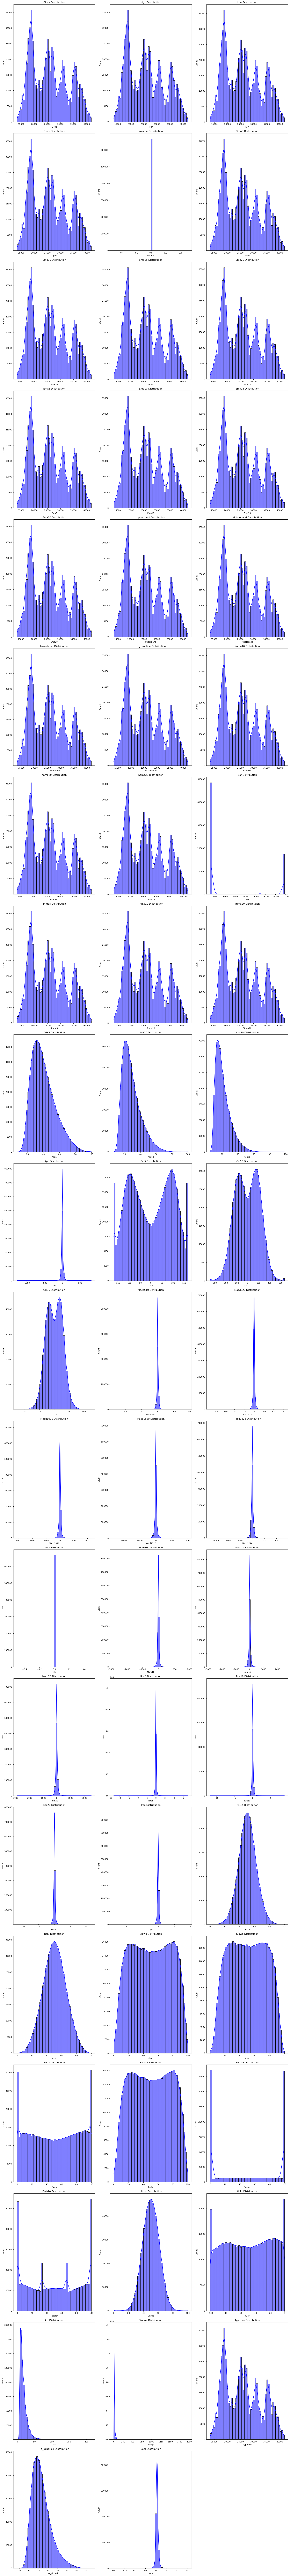

In [3]:
numeric_columns = data.select_dtypes(include=['float64', 'int64']).columns

# Plot distributions
plt.figure(figsize=(20, len(numeric_columns) * 3))  # Adjust figure size for all columns
for i, column in enumerate(numeric_columns, 1):
    plt.subplot(len(numeric_columns) // 3 + 1, 3, i)  # Arrange in rows of 3
    sns.histplot(data[column], kde=True, bins=50, color='blue')
    plt.title(f'{column.capitalize()} Distribution')
    plt.xlabel(column.capitalize())
    plt.tight_layout()

plt.show()

In [4]:
data['date'] = pd.to_datetime(data['date'])

print(data.duplicated().sum())

print(data.describe())

0
               close           high            low           open    volume  \
count  666290.000000  666290.000000  666290.000000  666290.000000  666290.0   
mean    26121.263584   26130.018981   26112.495037   26121.294461       0.0   
std      6995.769814    6997.767504    6993.701257    6995.745969       0.0   
min     13442.800000   13471.450000   13411.600000   13441.550000       0.0   
25%     19401.700000   19407.662500   19395.012500   19401.500000       0.0   
50%     25533.525000   25539.550000   25527.625000   25533.350000       0.0   
75%     31383.450000   31391.950000   31375.037500   31383.787500       0.0   
max     41820.850000   41834.550000   41803.100000   41821.950000       0.0   

                sma5          sma10          sma15          sma20  \
count  666290.000000  666290.000000  666290.000000  666290.000000   
mean    26121.195841   26121.111259   26121.026831   26120.942442   
std      6995.708644    6995.636849    6995.565664    6995.494516   
min     13

It consists of 60 columns of OHLC-Open, High, Low, Close-values, together with a number of technical indicators: SMA5, EMA10, RSI14, and derived metrics: ATR, BETA, ULTOSC, plus a date column in string format, indicating the time of data collection. There are 666,290 rows in this data, occupying 305 MB memory. There are no null values in any column; therefore, the information is complete. The data types are mostly float64 about 58 out of 60 columns-with the date column stored as an object (string), which needs conversion into a datetime format for further processing.


### (b) Pre-processing

In [5]:
# The volume column contains only zeros and does not provide any information. We can safely drop it:
data.drop(columns=['volume'], inplace=True)

# checking outliers
for col in ['ATR', 'Trange']:
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    data[col] = data[col].clip(lower_bound, upper_bound)

# checking for constant or redundant columns
low_variance_cols = [col for col in data.columns if data[col].nunique() == 1]
print("Low variance columns:", low_variance_cols)

# Drop constant columns if any
data.drop(columns=low_variance_cols, inplace=True)


Low variance columns: ['MFI']


                  date     close      high       low      open      sma5  \
date          1.000000  0.873324  0.873473  0.873172  0.873323  0.873326   
close         0.873324  1.000000  0.999999  0.999999  0.999997  0.999995   
high          0.873473  0.999999  1.000000  0.999998  0.999999  0.999996   
low           0.873172  0.999999  0.999998  1.000000  0.999999  0.999996   
open          0.873323  0.999997  0.999999  0.999999  1.000000  0.999997   
sma5          0.873326  0.999995  0.999996  0.999996  0.999997  1.000000   
sma10         0.873327  0.999988  0.999989  0.999989  0.999990  0.999997   
sma15         0.873329  0.999982  0.999983  0.999982  0.999984  0.999991   
sma20         0.873330  0.999975  0.999976  0.999975  0.999977  0.999985   
ema5          0.873327  0.999997  0.999997  0.999997  0.999998  1.000000   
ema10         0.873330  0.999992  0.999993  0.999992  0.999993  0.999998   
ema15         0.873333  0.999987  0.999988  0.999987  0.999989  0.999994   
ema20       

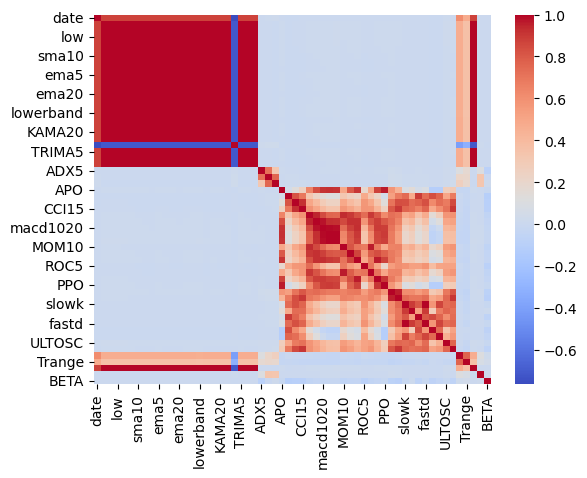

In [6]:
# Correlation Matrix:
sns.heatmap(data.corr(), annot=False, cmap='coolwarm')

corr_matrix = data.corr()
print(corr_matrix)

In [7]:
# finding pairs of highly correlated features (correlation > 0.9)

high_corr_pairs = []
for col1 in corr_matrix.columns:
    for col2 in corr_matrix.columns:
        if col1 != col2 and abs(corr_matrix[col1][col2]) > 0.9:
            high_corr_pairs.append((col1, col2))

print("Highly correlated pairs (correlation > 0.9):")
for pair in high_corr_pairs:
    print(f"{pair[0]} and {pair[1]}: {corr_matrix[pair[0]][pair[1]]}")




Highly correlated pairs (correlation > 0.9):
close and high: 0.9999987441950305
close and low: 0.9999987527969653
close and open: 0.9999974120483308
close and sma5: 0.9999950852351263
close and sma10: 0.9999883221241855
close and sma15: 0.9999815626867309
close and sma20: 0.9999747409545078
close and ema5: 0.9999967203482948
close and ema10: 0.9999917026261347
close and ema15: 0.9999865911172102
close and ema20: 0.9999814268348824
close and upperband: 0.9999862541810912
close and middleband: 0.9999950852351263
close and lowerband: 0.999987473346059
close and HT_TRENDLINE: 0.9999654579044662
close and KAMA10: 0.999991477202255
close and KAMA20: 0.9999848216525031
close and KAMA30: 0.9999786962830004
close and TRIMA5: 0.9999944282765599
close and TRIMA10: 0.9999867252148169
close and TRIMA20: 0.9999711299280775
close and TYPPRICE: 0.9999996876080602
high and close: 0.9999987441950305
high and low: 0.9999978055153868
high and open: 0.9999986474279564
high and sma5: 0.9999958506014278
high

The dataset represents the wide range of OHLC prices: from 13,442.80 to 41,821.95 with an average of about 26121 and a standard deviation of 6995 which points to great variation in prices over time. Technical indicators such as SMA5 and EMA5 are very close to price metrics while volatility indicators for example, ATR and Trange it show great variability reflecting different conditions of the market. The volume column has consistently zero values and therefore cannot be considered informative for predictive modeling. The oscillators, ULTOSC and WILLR, have varied ranges. the WILLR ranges within its full theoretical range of -100 to 0. The BETA metric includes some outliers in the range of -20.19 to 15.31 even though most values are concentrated around the 0.58 level. There are no missing values to complicate processing.


### (c) Feature Engineering

In [ ]:
# data.to_csv("cleaned_data.csv", index=False)
# data = pd.read_csv("cleaned_data.csv")



In [ ]:
# Create lag features for close price
for lag in range(1, 6):  
    data[f'close_lag_{lag}'] = data['close'].shift(lag)

    type(data)

# Rolling mean and standard deviation for close price
data['rolling_mean_5'] = data['close'].rolling(window=5).mean()
data['rolling_std_5'] = data['close'].rolling(window=5).std()

# Rolling features for technical indicators
data['RSI_rolling_mean_5'] = data['RSI14'].rolling(window=5).mean()

data['close_pct_change'] = data['close'].pct_change()
data['high_pct_change'] = data['high'].pct_change()

print(data['date'].dtype)

data['date'] = pd.to_datetime(data['date'], errors='coerce')

print(data['date'].head())
print(data['date'].dtype)

data['hour'] = data['date'].dt.hour
data['minute'] = data['date'].dt.minute
data['day_of_week'] = data['date'].dt.dayofweek

data.dropna(subset=['date'], inplace=True)

object
0   2015-01-09 10:18:00+05:30
1   2015-01-09 10:19:00+05:30
2   2015-01-09 10:20:00+05:30
3   2015-01-09 10:21:00+05:30
4   2015-01-09 10:22:00+05:30
Name: date, dtype: datetime64[ns, UTC+05:30]
datetime64[ns, UTC+05:30]


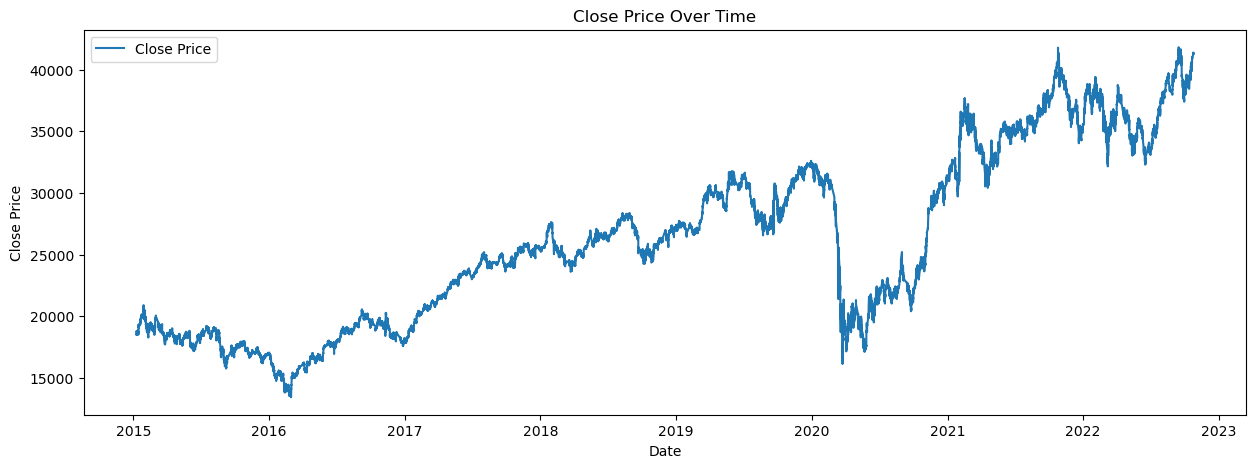

In [28]:
# Plotting close price over time
plt.figure(figsize=(15, 5))
plt.plot(data['date'], data['close'], label='Close Price')
plt.title('Close Price Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()


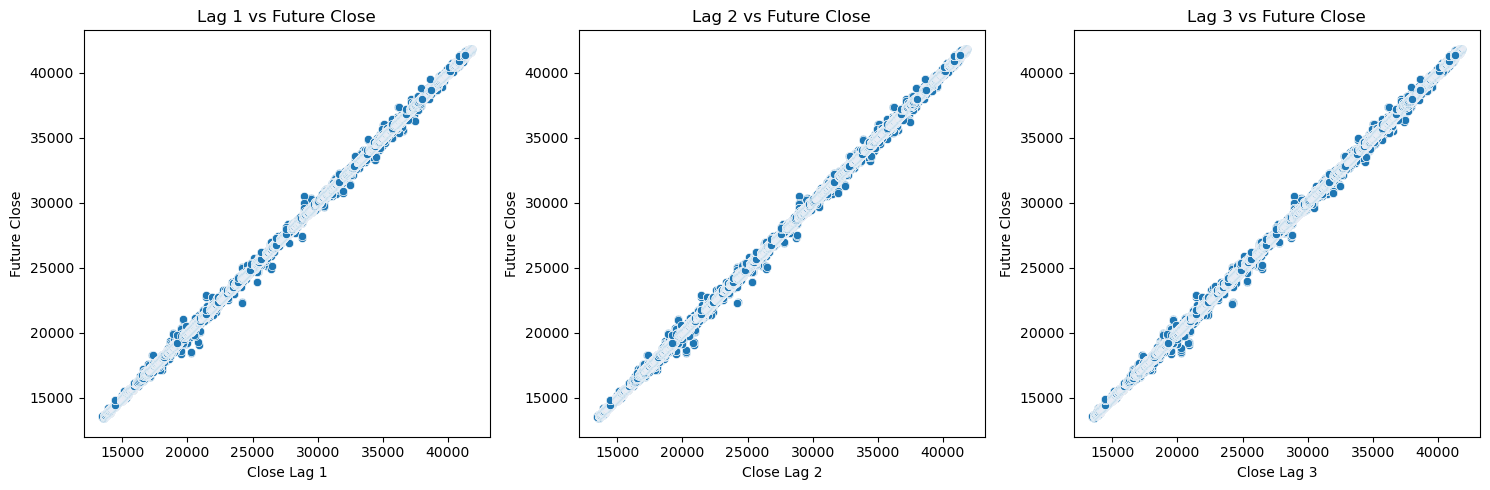

In [29]:
data['price_volatility'] = data['high'] - data['low']
data['sma5_vs_close'] = data['close'] - data['sma5']

# Target: Future price
data['future_close'] = data['close'].shift(-1)
data.dropna(inplace=True)

# Features and target
X = data.drop(columns=['future_close', 'date'])
y = data['future_close']

# Scatter plots for lag features and target
plt.figure(figsize=(15, 5))
for i, lag in enumerate(range(1, 4), 1):
    plt.subplot(1, 3, i)
    sns.scatterplot(x=data[f'close_lag_{lag}'], y=data['future_close'])
    plt.title(f'Lag {lag} vs Future Close')
    plt.xlabel(f'Close Lag {lag}')
    plt.ylabel('Future Close')
plt.tight_layout()
plt.show()



In [30]:
# Spliting data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


The above code performs some data preprocessing and feature engineering on the stock price dataset. First, it saves and reloads the dataset as a CSV. It then generates lag features on the 'close' price, calculating previous day values from 1 to 5 days. Furthermore, rolling mean and standard deviation features for the 'close' price over a window size of 5 days are computed. The code also calculates the 5-day rolling mean of the RSI and percentage changes for 'close' and 'high' prices. It then converts the 'date' column to datetime format and extracts the hour, minute, and day of the week for further analysis. It drops missing values in the 'date' column. A plot is created for 'close' price against time. Other features that are added include price volatility and the difference between 'close' price and a 5-day moving average, along with the target feature, which is the future 'close' price. The dataset is then divided into training and testing sets, with features standardized using a StandardScaler. Lastly, scatter plots for lag features versus the future 'close' price are generated. Data are prepared for modeling by separating out features from the target for machine learning tasks.


### (d) Model Implementation and Evaluation

### Linear Regression:

In [39]:
linear_model = LinearRegression()
linear_model.fit(X_train_scaled, y_train)

# Predictions
y_pred_linear = linear_model.predict(X_test_scaled)

# Evaluate the model
linear_mse = mean_squared_error(y_test, y_pred_linear)
linear_r2 = r2_score(y_test, y_pred_linear)

print(f"Linear Regression - MSE: {linear_mse}, R²: {linear_r2}")

comparison = pd.DataFrame({'Actual': y_test,'Predicted': y_pred_linear})
comparison['Difference'] = comparison['Actual'] - comparison['Predicted']
print(comparison.head())

Linear Regression - MSE: 368.3772154415914, R²: 0.9999924674556219
          Actual     Predicted  Difference
556457  35409.25  35406.296114    2.953886
62449   17212.30  17199.904309   12.395691
513552  31966.75  31954.879549   11.870451
589741  36410.15  36420.917505  -10.767505
92711   15299.10  15302.159671   -3.059671


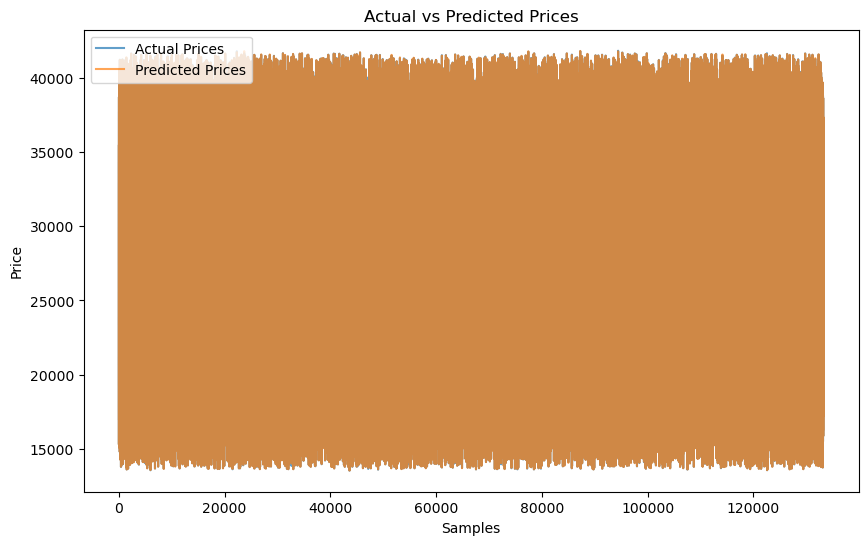

In [33]:
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual Prices', alpha=0.7)
plt.plot(y_pred_linear, label='Predicted Prices', alpha=0.7)
plt.title('Actual vs Predicted Prices')
plt.xlabel('Samples')
plt.ylabel('Price')
plt.legend()
plt.show()

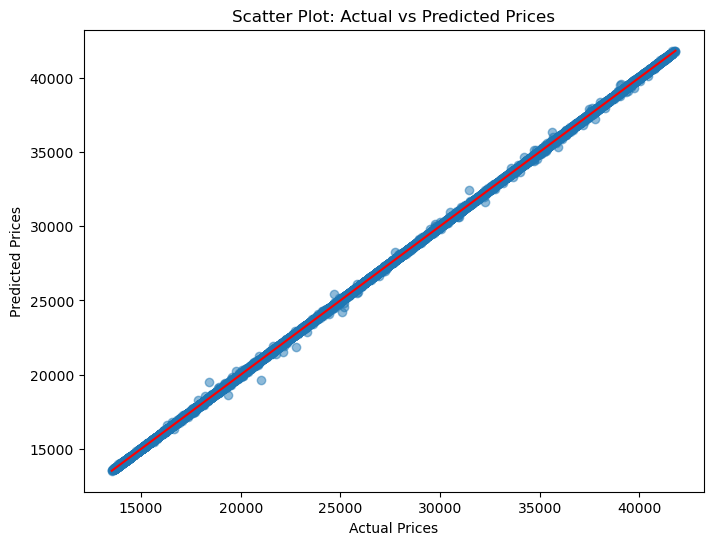

In [34]:
#scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_linear, alpha=0.5)
plt.title('Scatter Plot: Actual vs Predicted Prices')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')
plt.show()

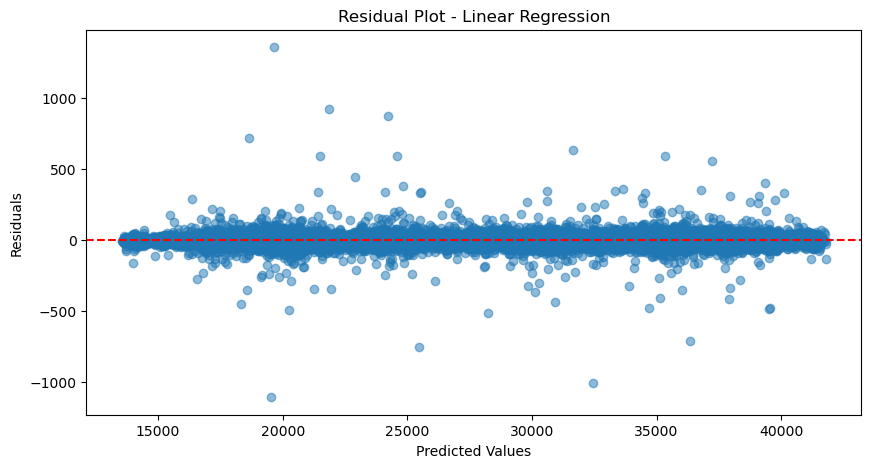

In [35]:
# Residual plot
residuals = y_test - y_pred_linear
plt.figure(figsize=(10, 5))
plt.scatter(y_pred_linear, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residual Plot - Linear Regression')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()

### Lasso Regression:

In [36]:
lasso_model = Lasso(alpha=0.1) 
lasso_model.fit(X_train_scaled, y_train)

# Predictions
y_pred_lasso = lasso_model.predict(X_test_scaled)

# Evaluate the model
lasso_mse = mean_squared_error(y_test, y_pred_lasso)
lasso_r2 = r2_score(y_test, y_pred_lasso)

print(f"Lasso Regression - MSE: {lasso_mse}, R²: {lasso_r2}")

Lasso Regression - MSE: 368.71060573804624, R²: 0.9999924606384869


### Elastic net:

In [37]:
elastic_model = ElasticNet(alpha=0.1, l1_ratio=0.5)
elastic_model.fit(X_train_scaled, y_train)

# Predictions
y_pred_elastic = elastic_model.predict(X_test_scaled)

# Evaluate the model
elastic_mse = mean_squared_error(y_test, y_pred_elastic)
elastic_r2 = r2_score(y_test, y_pred_elastic)

print(f"Elastic Net - MSE: {elastic_mse}, R²: {elastic_r2}")


Elastic Net - MSE: 883.319238962916, R²: 0.9999819379671471


c:\Users\Dipen\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.642e+10, tolerance: 2.609e+09
  model = cd_fast.enet_coordinate_descent(


(e) Comparative Analysis

Model Performance Comparison:
Linear Regression - MSE: 368.3772154415914, R²: 0.9999924674556219
Lasso Regression  - MSE: 368.71060573804624, R²: 0.9999924606384869
Elastic Net       - MSE: 883.319238962916, R²: 0.9999819379671471


<Axes: >

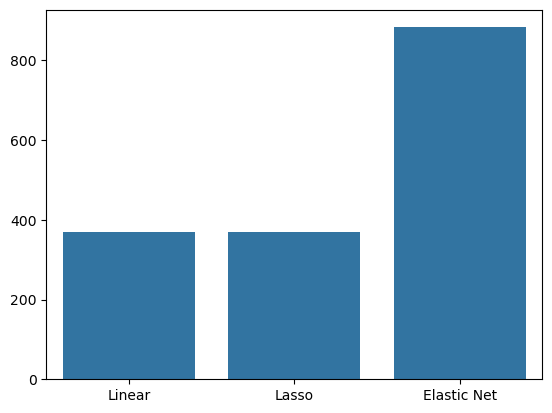

In [38]:
print("Model Performance Comparison:")
print(f"Linear Regression - MSE: {linear_mse}, R²: {linear_r2}")
print(f"Lasso Regression  - MSE: {lasso_mse}, R²: {lasso_r2}")
print(f"Elastic Net       - MSE: {elastic_mse}, R²: {elastic_r2}")

sns.barplot(x=['Linear', 'Lasso', 'Elastic Net'], y=[linear_mse, lasso_mse, elastic_mse])

sns.barplot(x=['Linear', 'Lasso', 'Elastic Net'], y=[linear_r2, lasso_r2, elastic_r2])

The code now fits three regression models which are Linear Regression, Lasso Regression, and Elastic Net Regressio. it works on the prepared dataset to forecast future stock prices. It trains the Linear Regression model on the scaled training data and makes predictions on the test set. The model is then evaluated on the Mean Squared Error and R-squared, returning an MSE of 368.38 and an R² of 0.99999, which shows very accurate predictions. A comparison of actual vs. predicted values is shown, along with the difference between them. It is recommended to adopt signal graphs, scatter plots, and residual plots as the methods of visualization to check the fitness of the model. The Lasso Regression, for an alpha value of 0.1, results in an MSE of 368.71 and an R² of 0.99999, slightly worse than Linear Regression. Finally, the Elastic Net model with an alpha of 0.1 and an L1 ratio of 0.5 has an MSE of 883.32 and an R² of 0.99998, which is slightly worse than the other two models. This result indicates that all three models perform well on this dataset, and Linear Regression performs the best among them.


### (f)Ethical Issues in Collecting Nifty Bank Data

1. **Data Privacy and Confidentiality**: 
Stock data often contains sensitive proprietary information, such as institutional trading strategies or order flows. Unauthorized use or exposure of such data can breach privacy agreements and lead to ethical violations.

2. **Data Source Attribution**:
Improper attribution of data to the broker or third-party provider will result in legal disputes and ethical violations.

3. **Data Manipulation and Misrepresentation**: 
Manipulated or incomplete data can distort research outcomes or financial models, leading to incorrect insights and poor decision-making.

4. **Legal Regulation Compliance**:
The collection and usage of stock data has to be done in strict adherence with the existing financial regulations and legal standards. Breaches could attract fines and abuses of ethical practices.

5. **Potential Misuse of Data**: 
The stock data collected can then be exploited for unethical purposes: market manipulation, insider trading, or spreading misleading financial advice, all harmful to market integrity.


### (g) Bibliography

1. **Scikit-learn Documentation**  
   Scikit-learn provides me comprehensive resources on various machine learning models including Gaussian Naive Bayes and K nearest neighbors.  
   [Scikit-learn Documentation](https://scikit-learn.org/stable/)

2. **ChatGPT**  
   ChatGPT helped me identify errors while writing code and understand their meanings to solve problems. It also assisted in breaking down detailed tasks and ensuring smooth project flow.

3. **Stack Overflow**  
   Stack Overflow was invaluable in solving specific errors and troubleshooting issues while working on the dataset and performing tasks in the project.
